In [47]:
a = "stoems"
str.isalnum(a[3])

True

In [45]:
str = raw_input()
print any(c.isalnum()  for c in str)
print any(c.isalpha() for c in str)
print any(c.isdigit() for c in str)
print any(c.islower() for c in str)
print any(c.isupper() for c in str)


 True 
 False


eval as a hacky solution. eval should only ever be used with caution and there's usually a better solution. It's fragile (you may accidentally create invalid code) and can be dangerous (can offer ways for malicious code to be injected). It's also significantly slower, because the python code created by eval has to be recompiled on every iteration.

You can do this more cleanly and safely a couple of ways. You could use getattr(). But I prefer just using function references. Remember that class methods are just functions with an object as the first parameter - true in any OO language but directly visible and usable from Python.

In [ ]:
for method in [str.isalnum, str.isalpha, str.isdigit, str.islower, str.isupper]:
    print any(method(c) for c in s)

In [ ]:
t = type(s)
for method in [t.isalnum, t.isalpha, t.isdigit, t.islower, t.isupper]:
    print any(method(c) for c in s)

In [1065]:
%matplotlib inline
import matplotlib
import seaborn as sns

sns.set()
matplotlib.rcParams['figure.dpi'] = 144

In [1066]:
from static_grader import grader

# The New York Social Graph


[New York Social Diary](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/) provides a
fascinating lens onto New York's socially well-to-do.  The data forms a natural social graph for New York's social elite.  Take a look at this page of a recent [run-of-the-mill holiday party](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2014/holiday-dinners-and-doers). Please note that these links point to the internet archive, as the original website has recently removed most of its archives. Many of the images no longer load, but all the HTML is still there.

Besides the brand-name celebrities, you will notice the photos have carefully annotated captions labeling those that appear in the photos.  We can think of this as implicitly implying a social graph: there is a connection between two individuals if they appear in a picture together.

For this project, we will assemble the social graph from photo captions for parties dated December 1, 2014, and before.  Using this graph, we can make guesses at the most popular socialites, the most influential people, and the most tightly coupled pairs.

We will attack the project in three phases:
1. Get a list of all the photo pages to be analyzed.
2. Parse all of the captions on a sample page.
3. Parse all of the captions on all pages, and assemble the graph.

## Phase One


The first step is to crawl the data.  We want photos from parties on or before December 1st, 2014.  Go to the [Party Pictures Archive](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures) to see a list of (party) pages.  We want to get the url for each party page, along with its date.

Here are some packages that you may find useful.  You are welcome to use others, if you prefer.

In [1067]:
import requests
import dill
from bs4 import BeautifulSoup
from datetime import datetime
import re

We recommend using Python [Requests](http://docs.python-requests.org/en/master/) to download the HTML pages, and [BeautifulSoup](https://www.crummy.com/software/BeautifulSoup/) to process the HTML.  Let's start by getting the [first page](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures).

In [1068]:
page = requests.get("https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures")# Use requests.get to download the page.
type(page)

requests.models.Response

Now, we process the text of the page with BeautifulSoup.

In [1069]:
soup = BeautifulSoup(page.text, "lxml")
type(soup)

bs4.BeautifulSoup

This page has links to 50 party pages. Look at the structure of the page and determine how to isolate those links.  Your browser's developer tools (usually `Cmd`-`Option`-`I` on Mac, `Ctrl`-`Shift`-`I` on others) offer helpful tools to explore the structure of the HTML page.

Once you have found a pattern, use BeautifulSoup's [select](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#css-selectors) or [find_all](https://www.crummy.com/software/BeautifulSoup/bs4/doc/#find) methods to get those elements.

In [1070]:
links = soup.find_all('div', attrs = {'class': 'views-row'})

There should be 50 per page.

In [1071]:
assert len(links) == 50

Let's take a look at that first link.  Figure out how to extract the URL of the link, as well as the date.  You probably want to use `datetime.strptime`.  See the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior) for reference.

In [1072]:
links[0]

<div class="views-row views-row-1 views-row-odd views-row-first">
<span class="views-field views-field-title"> <span class="field-content"><a href="/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams">Kicks offs, sing offs, and pro ams</a></span> </span>
<span class="views-field views-field-created"> <span class="field-content">Friday, September 11, 2015</span> </span> </div>

In [1073]:
link = links[0]
link.get_text()
# Check that the title and date match what you see visually.

'\n Kicks offs, sing offs, and pro ams \n Friday, September 11, 2015  '

In [1074]:
s = link.text
date = re.findall(r'(January|February|March|April|May|June|July|August|September|October|November|December)\s(\d\d?),\s(\d\d\d\d)', s)
date = ':'.join(date[0])
date = datetime.strptime(date, "%B:%d:%Y")
date

datetime.datetime(2015, 9, 11, 0, 0)

In [1075]:
# Extracting URLs from the attribute href in the <a> tags.
link.a.get('href')

'/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams'

For purposes of code reuse, let's put that logic into a function.  It should take the link element and return the URL and date parsed from it.

In [1076]:
def get_link_date(el):
    url = el.a.get('href')
    
    date = re.findall(r'(January|February|March|April|May|June|July|August|September|October|November|December)\s(\d\d?),\s(\d\d\d\d)', el.text)
    date = ':'.join(date[0])
    date = datetime.strptime(date, "%B:%d:%Y")
    
    return url, date

get_link_date(link)

('/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/kicks-offs-sing-offs-and-pro-ams',
 datetime.datetime(2015, 9, 11, 0, 0))

You may want to check that it works as you expected.

Once that's working, let's write another function to parse all of the links on a page.  Thinking ahead, we can make it take a Requests [Response](http://docs.python-requests.org/en/master/api/#requests.Response) object and do the BeautifulSoup parsing within it.

In [1077]:
def get_links(response, typ = 'request'):
    if typ == 'request':
        soup = BeautifulSoup(response.text, "lxml")
    elif typ == 'future':
        soup = BeautifulSoup(response.result().content, "lxml")
    else:
        return 'response type not recognized'
    links = soup.find_all('div', attrs = {'class': 'views-row'})
    
    link_dates = [get_link_date(link) for link in links]
    
    return link_dates # A list of URL, date pairs

In [1078]:
links_dates = get_links(page)
print(links_dates[0][1])
links_dates[0][1] > datetime(2014, 12, 1)

2015-09-11 00:00:00


True

If we run this on the previous response, we should get 50 pairs.

In [1079]:
assert len(get_links(page)) == 50

But we only want parties with dates on or before the first of December, 2014.  Let's write a function to filter our list of dates to those at or before a cutoff.  Using a keyword argument, we can put in a default cutoff, but allow us to test with others.

In [1080]:
def filter_by_date(links, cutoff=datetime(2014, 12, 1)):
    filtered_links=[]
    for l in links:
        if(l[1] <= cutoff):
            filtered_links.append(l)
        else:
            next
    return(filtered_links)
    # Return only the elements with date <= cutoff

With the default cutoff, there should be no valid parties on the first page.  Adjust the cutoff date to check that it is actually working.

In [1081]:
assert len(filter_by_date(get_links(page))) == 0

In [1082]:
len(filter_by_date(get_links(page), cutoff=datetime(2019, 1,1)))

50

Now we should be ready to get all of the party URLs.  Click through a few of the index pages to determine how the URL changes.  Figure out a strategy to visit all of them.

HTTP requests are generally IO-bound.  This means that most of the time is spent waiting for the remote server to respond.  If you use `requests` directly, you can only wait on one response at a time.  [requests-futures](https://github.com/ross/requests-futures) lets you wait for multiple requests at a time.  You may wish to use this to speed up the downloading process.

In [1083]:
from requests_futures.sessions import FuturesSession
session = FuturesSession(max_workers=10)

page0 = session.get('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures')

type(page0)

futures=[page0]
for page_num in range(1,26):
    url="https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures?page={}".format(page_num)
    futures.append(session.get(url))

print(len(futures))

In [1087]:
link_list = []
[link_list.extend(get_links(future, 'future')) for future in futures]
link_list = filter_by_date(link_list)
print(len(link_list))
print(link_list[0])
print(link_list[45])
print(link_list[452])
print(link_list[1020])

1193
('/web/20150918040703/http://www.newyorksocialdiary.com/party-pictures/2014/the-thanksgiving-day-parade-from-the-ground-up', datetime.datetime(2014, 12, 1, 0, 0))
('/web/20150918040708/http://www.newyorksocialdiary.com/party-pictures/2014/its-showtime', datetime.datetime(2014, 6, 19, 0, 0))
('/web/20150910152250/http://www.newyorksocialdiary.com/party-pictures/2011/sunrise-sunset', datetime.datetime(2011, 5, 23, 0, 0))
('/web/20150910134150/http://www.newyorksocialdiary.com/party-pictures/2008/dessert-and-dancing', datetime.datetime(2008, 3, 14, 0, 0))


In the end, you should have 1193 parties.

In [1088]:
assert len(link_list) == 1193

In case we need to restart the notebook, we should save this information to a file.  There are many ways you could do this; here's one using `dill`.

In [1089]:
dill.dump(link_list, open('nysd-links.pkd', 'wb'))

To restore the list, we can just load it from the file.  When the notebook is restarted, you can skip the code above and just run this command.

In [1090]:
link_list = dill.load(open('nysd-links.pkd', 'rb'))

## Question 1: histogram


Get the number of party pages for the 95 months (that is, month-year pair) in the data.  Represent this histogram as a list of 95 tuples, each of the form `("Dec-2014", 1)`.  Note that you can convert `datetime` objects into these sort of strings with `strftime` and the [format codes for dates](https://docs.python.org/3/library/datetime.html#strftime-and-strptime-behavior).

Plot the histogram for yourself.  Do you see any trends?

In [1091]:
import numpy as np
import pandas as pd

In [1092]:
dates = pd.Series([link[1] for link in link_list])
type(dates[0])

pandas._libs.tslibs.timestamps.Timestamp

In [1392]:
df = pd.DataFrame(link_list)
df.columns = ['url', 'date']
df.head()

,url,date
0,/web/20150918040703/http://www.newyorksocialdi...,2014-12-01
1,/web/20150918040703/http://www.newyorksocialdi...,2014-11-24
2,/web/20150918040703/http://www.newyorksocialdi...,2014-11-20
3,/web/20150918040703/http://www.newyorksocialdi...,2014-11-18
4,/web/20150918040703/http://www.newyorksocialdi...,2014-11-17


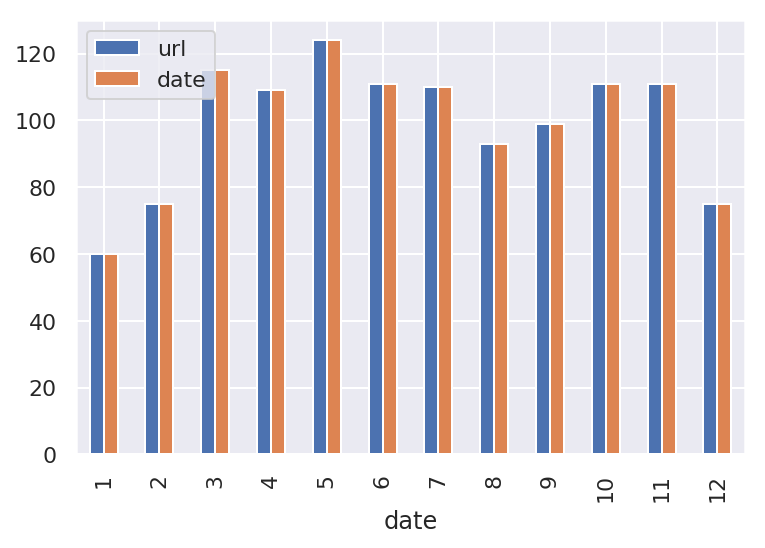

In [1393]:
df.groupby(df["date"].dt.month).count().plot(kind="bar")

In [ ]:
df.set_index('date', inplace=True)

In [1400]:
g = df.groupby(pd.Grouper(freq="M"))
count_df = g.count()
count_df.reset_index(inplace=True)
count_df['date'] =  pd.to_datetime(count_df['date'], format='%Y-%m-%d')
count_df.head()

<bound method DataFrameGroupBy.aggregate of <pandas.core.groupby.groupby.DataFrameGroupBy object at 0x7fa6b3906080>>

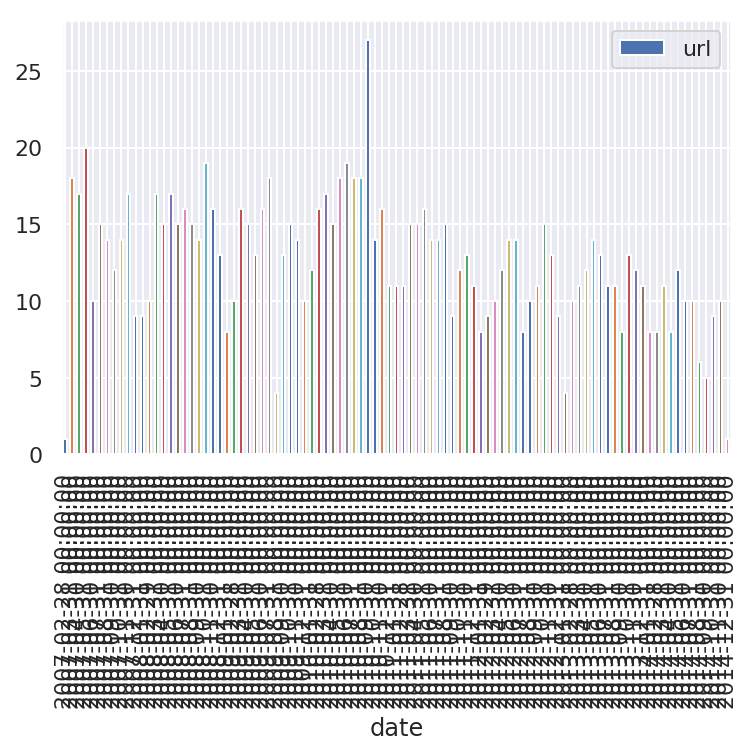

In [1096]:
plt = count_df.plot.bar(x='date', y = 'url')

In [1097]:
type(count_df['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [1098]:
count_df['date'] = count_df['date'].dt.strftime('%b-%Y')
count_df.head()


,date,url
0,Feb-2007,1
1,Mar-2007,18
2,Apr-2007,17
3,May-2007,20
4,Jun-2007,10


In [1099]:
histogram = [tuple(x) for x in count_df.values]  # Replace this fake answer with your real results
histogram

[('Feb-2007', 1),
 ('Mar-2007', 18),
 ('Apr-2007', 17),
 ('May-2007', 20),
 ('Jun-2007', 10),
 ('Jul-2007', 15),
 ('Aug-2007', 14),
 ('Sep-2007', 12),
 ('Oct-2007', 14),
 ('Nov-2007', 17),
 ('Dec-2007', 9),
 ('Jan-2008', 9),
 ('Feb-2008', 10),
 ('Mar-2008', 17),
 ('Apr-2008', 15),
 ('May-2008', 17),
 ('Jun-2008', 15),
 ('Jul-2008', 16),
 ('Aug-2008', 15),
 ('Sep-2008', 14),
 ('Oct-2008', 19),
 ('Nov-2008', 16),
 ('Dec-2008', 13),
 ('Jan-2009', 8),
 ('Feb-2009', 10),
 ('Mar-2009', 16),
 ('Apr-2009', 15),
 ('May-2009', 13),
 ('Jun-2009', 16),
 ('Jul-2009', 18),
 ('Aug-2009', 4),
 ('Sep-2009', 13),
 ('Oct-2009', 15),
 ('Nov-2009', 14),
 ('Dec-2009', 10),
 ('Jan-2010', 12),
 ('Feb-2010', 16),
 ('Mar-2010', 17),
 ('Apr-2010', 15),
 ('May-2010', 18),
 ('Jun-2010', 19),
 ('Jul-2010', 18),
 ('Aug-2010', 18),
 ('Sep-2010', 27),
 ('Oct-2010', 14),
 ('Nov-2010', 16),
 ('Dec-2010', 11),
 ('Jan-2011', 11),
 ('Feb-2011', 11),
 ('Mar-2011', 15),
 ('Apr-2011', 15),
 ('May-2011', 16),
 ('Jun-2011', 14)

In [1100]:
grader.score('graph__histogram', histogram)

Your score:  0.9789473684210537


## Phase Two


In this phase, we we concentrate on getting the names out of captions for a given page.  We'll start with [the benefit cocktails and dinner](https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood) for [Lenox Hill Neighborhood House](http://www.lenoxhill.org/), a neighborhood organization for the East Side.

Take a look at that page.  Note that some of the text on the page is captions, but others are descriptions of the event.  Determine how to select only the captions.

In [1159]:
page = requests.get('https://web.archive.org/web/20151114014941/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood')
soup = BeautifulSoup(page.text, "lxml")
captions = soup.find_all('div', {'class': 'photocaption'})
len(captions)

109

By our count, there are about 110.  But if you're off by a couple, you're probably okay.

In [1160]:
assert abs(len(captions) - 110) < 5

Let's encapsulate this in a function.  As with the links pages, we want to avoid downloading a given page the next time we need to run the notebook.  While we could save the files by hand, as we did before, a checkpoint library like [ediblepickle](https://pypi.python.org/pypi/ediblepickle/1.1.3) can handle this for you.  (Note, though, that you may not want to enable this until you are sure that your function is working.)

You should also keep in mind that HTTP requests fail occasionally, for transient reasons.  You should plan how to detect and react to these failures.   The [retrying module](https://pypi.python.org/pypi/retrying) is one way to deal with this.

In [1161]:
from ediblepickle import checkpoint
import string
import os

cache_dir = 'cache'
if not os.path.exists(cache_dir):
    os.mkdir(cache_dir)

In [1162]:
path = "/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood"
x = '-'.join(path.split('/')[-2:])
x


'2015-celebrating-the-neighborhood'

In [1163]:
@checkpoint(
    key=lambda args, kwargs: '-'.join(args[0].split('/')[-2:])+'.p',
    work_dir=cache_dir
)

SyntaxError: unexpected EOF while parsing (<ipython-input-1163-6e8874980ad6>, line 4)

In [1259]:
def get_page_soup(path):
    page = requests.get('https://web.archive.org' + path)
    soup = BeautifulSoup(page.text, "lxml")
    return(soup)

def get_captions(soup):
    #page = requests.get('https://web.archive.org' + path)
    #soup = BeautifulSoup(page.text, "lxml")
    captions = soup.find_all('div', {'class': 'photocaption'})
    if len(captions) == 0:
        captions = soup.find_all('td', {'class': 'photocaption'})
    if len(captions) == 0:
        captions = soup.find_all('font', {'size': 1})
    captions = [caption.text for caption in captions]
    return captions

In [1260]:
#soup = get_page_soup(path)
soup = soups[1192]

In [1262]:
link_list[1192]

('/web/20150918040534/http://www.newyorksocialdiary.com/party-pictures/2007/orchids-growing-wild',
 datetime.datetime(2007, 2, 21, 0, 0))

In [1263]:
captions = get_captions(soup)
captions[0]

'Oscar\n                    Mora for Valentino'

This should get the same captions as before.

In [1168]:
assert captions == get_captions(get_page_soup("/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures/2015/celebrating-the-neighborhood"))

In [1169]:
import spacy as sp

In [1170]:
import spacy
nlp = spacy.load("en_core_web_sm")

In [1171]:
caption = captions[0]
caption

"Glenn Adamson, Simon Doonan, Victoire de Castellane, Craig Leavitt, Jerome Chazen, Andi Potamkin, Ralph Pucci, Kirsten Bailey, Edwin Hathaway, and Dennis Freedman at the Museum of Art and Design's annual MAD BALL. "

In [1172]:
doc = nlp(caption)
tokens = [token.pos_ for token in doc]
print(tokens)

['PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'PROPN', 'PROPN', 'PUNCT', 'CCONJ', 'PROPN', 'PROPN', 'ADP', 'DET', 'PROPN', 'ADP', 'PROPN', 'CCONJ', 'PROPN', 'PART', 'ADJ', 'PROPN', 'NOUN', 'PUNCT']


In [1173]:
for token in doc:
    print(token.text, token.pos_, token.dep_)
    

Glenn PROPN compound
Adamson PROPN ROOT
, PUNCT punct
Simon PROPN compound
Doonan PROPN conj
, PUNCT punct
Victoire PROPN compound
de PROPN compound
Castellane PROPN conj
, PUNCT punct
Craig PROPN compound
Leavitt PROPN conj
, PUNCT punct
Jerome PROPN compound
Chazen PROPN conj
, PUNCT punct
Andi PROPN compound
Potamkin PROPN conj
, PUNCT punct
Ralph PROPN compound
Pucci PROPN conj
, PUNCT punct
Kirsten PROPN compound
Bailey PROPN conj
, PUNCT punct
Edwin PROPN compound
Hathaway PROPN conj
, PUNCT punct
and CCONJ cc
Dennis PROPN compound
Freedman PROPN conj
at ADP prep
the DET det
Museum PROPN pobj
of ADP prep
Art PROPN pobj
and CCONJ cc
Design PROPN poss
's PART case
annual ADJ amod
MAD PROPN compound
BALL NOUN conj
. PUNCT punct


Now that we have some sample captions, let's start parsing names out of those captions.  There are many ways of going about this, and we leave the details up to you.  Some issues to consider:

  1. Some captions are not useful: they contain long narrative texts that explain the event.  Try to find some heuristic rules to separate captions that are a list of names from those that are not.  A few heuristics include:
    - look for sentences (which have verbs) and as opposed to lists of nouns. For example, [`nltk` does part of speech tagging](http://www.nltk.org/book/ch05.html) but it is a little slow. There may also be heuristics that accomplish the same thing.
    - Similarly, spaCy's [entity recognition](https://spacy.io/docs/usage/entity-recognition) could be useful here.
    - Look for commonly repeated threads (e.g. you might end up picking up the photo credits or people such as "a friend").
    - Long captions are often not lists of people.  The cutoff is subjective, but for grading purposes, *set that cutoff at 250 characters*.
  2. You will want to separate the captions based on various forms of punctuation.  Try using `re.split`, which is more sophisticated than `string.split`. **Note**: The reference solution uses regex exclusively for name parsing.
  3. You might find a person named "ra Lebenthal".  There is no one by this name.  Can anyone spot what's happening here?
  4. This site is pretty formal and likes to say things like "Mayor Michael Bloomberg" after his election but "Michael Bloomberg" before his election.  Can you find other ('optional') titles that are being used?  They should probably be filtered out because they ultimately refer to the same person: "Michael Bloomberg."
  5. There is a special case you might find where couples are written as eg. "John and Mary Smith". You will need to write some extra logic to make sure this properly parses to two names: "John Smith" and "Mary Smith".
  6. When parsing names from captions, it can help to look at your output frequently and address the problems that you see coming up, iterating until you have a list that looks reasonable. This is the approach used in the reference solution. Because we can only asymptotically approach perfect identification and entity matching, we have to stop somewhere.
  
**Questions worth considering:**
  1. Who is Patrick McMullan and should he be included in the results? How would you address this?
  2. What else could you do to improve the quality of the graph's information?

In [1359]:
def filter_captions(caption_list):
    filtered_captions=[]
    for caption in caption_list:
        caption = caption.strip()
        if len(caption) > 250:
            next
        else:
            doc=nlp(caption)
            tokens=[token.pos_ for token in doc]
        
            if ( 'VERB' in tokens or
                 not 'PROPN' in tokens or
                 re.search('^[Tt]he\s', caption)
               ):
                #print(caption)
                next
                
            else:
                filtered_captions.append(caption)

    return(filtered_captions)

In [1357]:
filtered_captions = filter_captions(captions)
print(len(captions))
print(len(filtered_captions))
type(filtered_captions)

94
93


list

#### Test Cases

caption = filtered_captions[2]
#caption = "Althea Goodwin, Bruce Lee, and James Lederman"
#caption = "James Lederman and David Gloss"
#caption = "James and David Lederman"

caption


parts = re.split(r",\s+with\s+|\sat\s|,\s", caption)
#list_1 = [item for item in list_1 if item[2] >= 5 or item[3] >= 0.3]
parts = [part.strip() for part in parts if not re.search('\s?[Tt]he\s', part)]
parts

#part = parts[9]
part = "James and David Lederman"
part

p = re.search(r'^and\s(.*)', part) #if a part starts with and ie 'and Dennis Freedman'
print(p)

if p:
    names.append(p.group(1))
names

p = re.search(r'(.*)\sand\s(.*)', part) #if there's an and between two names
p
p.group(1)

re.search(r' ', p.group(2))
lastname = re.split(' ', p.group(2))[1]
lastname
p.group(1)+' '+lastname
p.group(2)

if p:
    #if there's a space in the first name, it's probably a full name
    if re.search(r' ', p.group(1)):
        names.append(p.group(1))
    else: #if not, it's prob just a first name as in 'Jane and John Doe'
        lastname = re.split(' ', p.group(2))[1]
    names.append(p.group(1)+' '+lastname)
    names.append(p.group(2))
names

In [1666]:
def get_names(caption):
    names = []
    caption = re.sub(r'\n', '', caption)
    caption = re.sub(r'M\.?D\.?', '', caption) #remove MD and M.D.
    caption = re.sub(r'Ph[Dd]', '', caption) #remove PhD and Phd
    caption = re.sub(r'friend\'?s?\'?', '', caption) #remove friend, friends, friend's, friends'
    caption = re.sub(r',\sa\s', ' ', caption) #replace ', a ' with a space
    caption = re.sub(r',\s?Jr.', ' Jr.', caption) #change 'James Lederman, Jr.' to James Lederman_Jr
    
    parts = re.split(r",?\s+with\s+|\sat\s|,\s", caption)
    parts = [part for part in parts if not re.search('\s?[Tt]he\s', part)]

    for part in parts:
        p = re.search(r'^and\s(.*)', part) #if a part starts with and ie 'and Dennis Freedman'
        if p:
            names.append(p.group(1))
        
        elif re.search(r'(.*)\sand\s(.*)', part):
            p = re.search(r'(.*)\sand\s(.*)', part) #if there's an 'and' between two names
            if p:
                #if there's a space in the first name, it's probably a full name
                if re.search(r' ', p.group(1)):
                    names.append(p.group(1))
                    names.append(p.group(2))
                elif re.search('. .', p.group(2)): #if not, it's prob just a first name as in 'Jane and John Doe'
                    #print(caption)
                    lastname = re.split(' ', p.group(2))[1]
                    names.append(p.group(1)+' '+lastname)
                    names.append(p.group(2))
                else:
                    next
        else:
            names.append(part)
    
    #strip whitespace and exclude Patrick McMullan, a photographer
    names = [name.strip() for name in names]
    names = [name for name in names if not re.search('Patrick McMullan', name)]
    #names = [name.strip("'s") for name in names if not re.search('"', name)]
    names = [name for name in names if not len(name)==0]
    return names

In [1605]:
caption

'Mandolins, guitars, accordions and more give Poor Old Shine their unique sound JHC Board members Bob Garry and Jim Kelsey with friends and family'

In [1486]:
caption = "Mandolins, guitars, accordions and more give Poor Old Shine their unique sound JHC Board members Bob Garry and Jim Kelsey with friends and family"

In [1487]:
doc=nlp(caption)
tokens=[token.pos_ for token in doc]

tokens

['NOUN',
 'PUNCT',
 'NOUN',
 'PUNCT',
 'NOUN',
 'CCONJ',
 'ADJ',
 'VERB',
 'PROPN',
 'PROPN',
 'VERB',
 'DET',
 'ADJ',
 'NOUN',
 'PROPN',
 'PROPN',
 'NOUN',
 'PROPN',
 'PROPN',
 'CCONJ',
 'PROPN',
 'PROPN',
 'ADP',
 'NOUN',
 'CCONJ',
 'NOUN']

In [1281]:
filtered_captions

["Glenn Adamson, Simon Doonan, Victoire de Castellane, Craig Leavitt, Jerome Chazen, Andi Potamkin, Ralph Pucci, Kirsten Bailey, Edwin Hathaway, and Dennis Freedman at the Museum of Art and Design's annual MAD BALL.",
 'Randy Takian',
 'Kamie Lightburn and Christopher Spitzmiller',
 'Christopher Spitzmiller and Diana Quasha',
 'Mariam Azarm, Sana Sabbagh, and Lynette Dallas',
 'Christopher Spitzmiller, Sydney Shuman, and Matthew Bees',
 'Christopher Spitzmiller and Tom Edelman',
 'Warren Scharf and Sydney Shuman',
 'Amory McAndrew and Sean McAndrew',
 'Sydney Shuman, Mario Buatta, and Helene Tilney',
 'Katherine DeConti and Elijah Duckworth-Schachter',
 'John Rosselli and Elizabeth Swartz',
 'Stephen Simcock, Lee Strock, and Thomas Hammer',
 'Searcy Dryden, Lesley Dryden, Richard Lightburn, and Michel Witmer',
 'Jennifer Cacioppo and Kevin Michael Barba',
 'Virginia Wilbanks and Lacary Sharpe',
 'Valentin Hernandez, Yaz Hernandez, Chele Farley, and James Farley',
 'Harry Heissmann, Ang

In [1282]:
names = [get_names(caption) for caption in filtered_captions]
names

[['Glenn Adamson',
  'Simon Doonan',
  'Victoire de Castellane',
  'Craig Leavitt',
  'Jerome Chazen',
  'Andi Potamkin',
  'Ralph Pucci',
  'Kirsten Bailey',
  'Edwin Hathaway',
  'Dennis Freedman'],
 ['Randy Takian'],
 ['Kamie Lightburn', 'Christopher Spitzmiller'],
 ['Christopher Spitzmiller', 'Diana Quasha'],
 ['Mariam Azarm', 'Sana Sabbagh', 'Lynette Dallas'],
 ['Christopher Spitzmiller', 'Sydney Shuman', 'Matthew Bees'],
 ['Christopher Spitzmiller', 'Tom Edelman'],
 ['Warren Scharf', 'Sydney Shuman'],
 ['Amory McAndrew', 'Sean McAndrew'],
 ['Sydney Shuman', 'Mario Buatta', 'Helene Tilney'],
 ['Katherine DeConti', 'Elijah Duckworth-Schachter'],
 ['John Rosselli', 'Elizabeth Swartz'],
 ['Stephen Simcock', 'Lee Strock', 'Thomas Hammer'],
 ['Searcy Dryden', 'Lesley Dryden', 'Richard Lightburn', 'Michel Witmer'],
 ['Jennifer Cacioppo', 'Kevin Michael Barba'],
 ['Virginia Wilbanks', 'Lacary Sharpe'],
 ['Valentin Hernandez', 'Yaz Hernandez', 'Chele Farley', 'James Farley'],
 ['Harry Hei

## Question 2: sample_names


Once you feel that your algorithm is working well on these captions, parse all of the captions and extract all the names mentioned.  Sort them alphabetically, by first name, and return the first hundred.

In [1283]:
sample_names = []

In [1284]:
[sample_names.extend(get_names(caption)) for caption in filtered_captions]
sample_names

['Glenn Adamson',
 'Simon Doonan',
 'Victoire de Castellane',
 'Craig Leavitt',
 'Jerome Chazen',
 'Andi Potamkin',
 'Ralph Pucci',
 'Kirsten Bailey',
 'Edwin Hathaway',
 'Dennis Freedman',
 'Randy Takian',
 'Kamie Lightburn',
 'Christopher Spitzmiller',
 'Christopher Spitzmiller',
 'Diana Quasha',
 'Mariam Azarm',
 'Sana Sabbagh',
 'Lynette Dallas',
 'Christopher Spitzmiller',
 'Sydney Shuman',
 'Matthew Bees',
 'Christopher Spitzmiller',
 'Tom Edelman',
 'Warren Scharf',
 'Sydney Shuman',
 'Amory McAndrew',
 'Sean McAndrew',
 'Sydney Shuman',
 'Mario Buatta',
 'Helene Tilney',
 'Katherine DeConti',
 'Elijah Duckworth-Schachter',
 'John Rosselli',
 'Elizabeth Swartz',
 'Stephen Simcock',
 'Lee Strock',
 'Thomas Hammer',
 'Searcy Dryden',
 'Lesley Dryden',
 'Richard Lightburn',
 'Michel Witmer',
 'Jennifer Cacioppo',
 'Kevin Michael Barba',
 'Virginia Wilbanks',
 'Lacary Sharpe',
 'Valentin Hernandez',
 'Yaz Hernandez',
 'Chele Farley',
 'James Farley',
 'Harry Heissmann',
 'Angela Clo

In [ ]:
unique_names = []
for name in sample_names:
    if not name in unique_names:
        unique_names.append(name)
    else:
        next
sample_names = unique_names


In [1286]:
#sample_names = ["Caroline Dean"] * 100

sample_names = sorted(sample_names)[:100]
print(sample_names)

['"KISS" friends', 'Alberto Villalobos', 'Alex Papachristidis', 'Alexandra Richards', 'Alexis Mersentes', 'Allison Minton', 'Amory McAndrew', 'Andi Potamkin', 'Angela Clofine', 'Anne Strickland', 'Barbara', 'Barbara Regna', 'Barbara Tober', 'Bette Midler', 'Bette Midler on stage', 'Bjorn Wallander', 'Bryna Pomp', 'C. Virginia Fields', 'Caroline Cokley', 'Caroline Dean', 'Celia Morrissette', 'Chele Farley', 'Chips Page', 'Christopher Spitzmiller', 'Clark', 'Craig Leavitt', 'Cynthia Adler', 'Dan Tishman', 'Darcy Stacom', 'David Duncan', 'David Rockwell', 'David Svanda', 'Davon Windsor', 'Debbie Bancroft', 'Deborah Lloyd', 'Deborah Marton', 'Dennis Freedman', 'Diana Quasha', 'Donald Tober', 'Donna Soloway', 'Doris Liebman', 'Douglas Little', 'Dr. Doug Steinbrech', 'Dr. Drew Schiff', 'Ebony G. Patterson', 'Edwin Hathaway', 'Elijah Duckworth-Schachter', 'Elizabeth Johnson', 'Elizabeth Swartz', 'Ellen Niven', 'Emily Leonard', 'Esra Munnell', 'Eveyln Subramaniam', 'Freddie Leiba', 'Geoffrey B

In [1287]:
#sample_names = ["Caroline Dean"] * 100

grader.score('graph__sample_names', sample_names)

Your score:  0.9600000000000006


Now, run this sort of test on a few other pages.  You will probably find that other pages have a slightly different HTML structure, as well as new captions that trip up your caption parser.  But don't worry if the parser isn't perfect -- just try to get the easy cases.

## Phase Three


Once you are satisfied that your caption scraper and parser are working, run this for all of the pages.  If you haven't implemented some caching of the captions, you probably want to do this first.

In [1288]:
# Scraping all of the pages could take 10 minutes or so.
len(futures)

26

In [1289]:
from requests_futures.sessions import FuturesSession
session = FuturesSession(max_workers=30)

page0 = session.get('https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures')

type(page0)

futures=[page0]
for page_num in range(1,26):
    url="https://web.archive.org/web/20150913224145/http://www.newyorksocialdiary.com/party-pictures?page={}".format(page_num)
    futures.append(session.get(url))

print(len(futures))

26


In [1290]:
def get_page_soup_fut(path):
    url = str('https://web.archive.org' + path)
    page = session.get(url)
    soup = BeautifulSoup(page.result().content, "lxml")
    return soup

# def get_captions(soup):
#     #page = requests.get('https://web.archive.org' + path)
#     #soup = BeautifulSoup(page.text, "lxml")
#     captions = soup.find_all('div', {'class': 'photocaption'})
#     captions = [caption.text for caption in captions]
#     return captions

soups = [get_page_soup_fut(link[0]) for link in link_list]

In [1291]:
#soups[1192]
len(soups)
type(soups[0])

bs4.BeautifulSoup

In [1341]:
caption_list = [get_captions(soup) for soup in soups]

In [1644]:
caption_list[1][0]

'The scene at   IDEAL School & Academy’s  10th\xa0Annual Gala.'

In [1645]:
x = re.search('IDEAL', caption_list[1][0])
print(x)

<_sre.SRE_Match object; span=(15, 20), match='IDEAL'>


In [1664]:
for captions in caption_list[2:3]:
    for caption in captions:
        if 'Jr.' in caption:
            print(caption)

Philip Wells, Henry "Hank" Aaron, and Ted Wells, Jr.


In [1668]:
caption = caption_list[2][22]
get_names(caption)

['Philip Wells', 'Henry "Hank" Aaron', 'Ted Wells Jr.']

#### Extract the names

In [1669]:
names_raw = []
for captions in caption_list:
    captions = filter_captions(captions)
    names_raw.extend([get_names(caption) for caption in captions])

In [1670]:
#remove certain cases
names = []
for name_set in names_raw:
    if 'a' in name_set:
        name_set.remove('a')
    if 'his wife' in name_set:
        name_set.remove('his wife')
    if 'guests' in name_set:
        name_set.remove('guests')
    
    names.append(name_set)

In [1691]:
names

[['Les Lieberman',
  'Barri Lieberman',
  'Isabel Kallman',
  'Trish Iervolino',
  'Ron Iervolino'],
 ['Chuck Grodin'],
 ['Diana Rosario',
  'Ali Sussman',
  'Sarah Boll',
  'Jen Zaleski',
  'Alysse Brennan',
  'Lindsay Macbeth'],
 ['Kelly', 'Tom Murro'],
 ['Ron Iervolino', 'Trish Iervolino', 'Russ Middleton', 'Lisa Middleton'],
 ['Barbara Loughlin', 'Dr. Gerald Loughlin', 'Debbie Gelston'],
 ['Julianne Michelle'],
 ['Heather Robinson',
  'Kiwan Nichols',
  'Jimmy Nichols',
  'Melanie Carbone',
  'Nancy Brown'],
 ['Bill Mack', 'Les Lieberman'],
 ['Dr. David Lyden', 'Patricia Sorenson'],
 ['Jimmy Cayne', 'Vince Tese', 'Pat Cayne'],
 ['Stuart Oran', 'Les Lieberman', 'Hilary Oran'],
 ['Vince Tese', 'Chuck Grodin'],
 ['Dwight Gooden', 'Les Lieberman'],
 ['Dr. Amy Cunningham-Bussel', 'Ray Mirra', 'Dr. Tyler Janovitz'],
 ['Dan Shedrick', 'Samara Heafitz'],
 ['Cass Adelman', 'Jason Adelman'],
 ['Bart Scott', 'Mark Laplander'],
 ['Mitch Rubin',
  'Audra Zuckerman',
  'Michelle Smith',
  'Kenne

#### Make list of unique names

In [1671]:
unique_names = []
for name_set in names:
    for name in name_set:
        if not name in unique_names:
            unique_names.append(name)
        else:
            next

In [1672]:
len(unique_names)

79817

In [1673]:
num_names = [len(name_set) for name_set in names]

In [1674]:
np.cumsum(np.array(num_names))[-1]

159085

For the remaining analysis, we think of the problem in terms of a
[network](http://en.wikipedia.org/wiki/Computer_network) or a
[graph](https://en.wikipedia.org/wiki/Graph_%28discrete_mathematics%29).  Any time a pair of people appear in a photo together, that is considered a link.  What we have described is more appropriately called an (undirected)
[multigraph](http://en.wikipedia.org/wiki/Multigraph) with no self-loops but this has an obvious analog in terms of an undirected [weighted graph](http://en.wikipedia.org/wiki/Graph_%28mathematics%29#Weighted_graph).  In this problem, we will analyze the social graph of the New York social elite.  We recommend using python's [`networkx`](https://networkx.github.io/) library.

In [1675]:

names[0]

['Les Lieberman',
 'Barri Lieberman',
 'Isabel Kallman',
 'Trish Iervolino',
 'Ron Iervolino']

All in all, you should end up with over 100,000 captions and more than 110,000 names, connected in about 200,000 pairs.

In [1676]:
import itertools  # itertools.combinations may be useful
import networkx as nx

In [1677]:
social_graph = nx.Graph()

In [1678]:
name_tuples = []
for name_set in names:
    name_tuples.extend(itertools.combinations(name_set, 2))

In [1679]:
name_pairs = [','.join(tup) for tup in name_tuples]

In [1680]:
name_pairs[:100]

['Les Lieberman,Barri Lieberman',
 'Les Lieberman,Isabel Kallman',
 'Les Lieberman,Trish Iervolino',
 'Les Lieberman,Ron Iervolino',
 'Barri Lieberman,Isabel Kallman',
 'Barri Lieberman,Trish Iervolino',
 'Barri Lieberman,Ron Iervolino',
 'Isabel Kallman,Trish Iervolino',
 'Isabel Kallman,Ron Iervolino',
 'Trish Iervolino,Ron Iervolino',
 'Diana Rosario,Ali Sussman',
 'Diana Rosario,Sarah Boll',
 'Diana Rosario,Jen Zaleski',
 'Diana Rosario,Alysse Brennan',
 'Diana Rosario,Lindsay Macbeth',
 'Ali Sussman,Sarah Boll',
 'Ali Sussman,Jen Zaleski',
 'Ali Sussman,Alysse Brennan',
 'Ali Sussman,Lindsay Macbeth',
 'Sarah Boll,Jen Zaleski',
 'Sarah Boll,Alysse Brennan',
 'Sarah Boll,Lindsay Macbeth',
 'Jen Zaleski,Alysse Brennan',
 'Jen Zaleski,Lindsay Macbeth',
 'Alysse Brennan,Lindsay Macbeth',
 'Kelly,Tom Murro',
 'Ron Iervolino,Trish Iervolino',
 'Ron Iervolino,Russ Middleton',
 'Ron Iervolino,Lisa Middleton',
 'Trish Iervolino,Russ Middleton',
 'Trish Iervolino,Lisa Middleton',
 'Russ Mid

In [1681]:
name_tuples_arr = np.array(name_pairs)

In [1682]:
unique, counts = np.unique(name_tuples_arr, return_counts=True)

In [1683]:
unique[:10]
#len(unique)

array(['"A Touch of Nature",Jerry Zelenka',
       '"Cazzette",Alexander Bjorklund', '"Cazzette",Sebastian Furrer',
       '"Fela" star Saycon Sengbloh,Michelle Paterson',
       '"Fifth Harmony",Ally Brooke', '"Fifth Harmony",Camila Cabello',
       '"Fifth Harmony",Dinah-Jane Hansen',
       '"Fifth Harmony",Lauren Jauregui',
       '"Fifth Harmony",Normani Hamilton', '"Lawson",Adam Pitts'],
      dtype='<U185')

In [1684]:
counts[:10]
len(counts)

138548

#get rid of all pairs with single incidence
bad = counts==1

unique = unique[~bad]
counts = counts[~bad]

In [1685]:
unique = [tuple(i.split(',')) for i in unique]

In [1686]:
unique[0]

('"A Touch of Nature"', 'Jerry Zelenka')

In [1687]:
#social_graph.add_edge(unique[0][0], unique[0][1], weight = counts[0])

In [1688]:
for i in range(len(unique)):
    social_graph.add_edge(unique[i][0], unique[i][1], weight = counts[i])

## Question 3: degree


The simplest question to ask is "who is the most popular"?  The easiest way to answer this question is to look at how many connections everyone has.  Return the top 100 people and their degree.  Remember that if an edge of the graph has weight 2, it counts for 2 in the degree.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 189.92
    "std": 87.8053034454
    "min": 124.0
    "25%": 138.0
    "50%": 157.0
    "75%": 195.0
    "max": 666.0

In [1689]:
node_degrees = social_graph.degree(nx.nodes(social_graph))
degree = sorted(social_graph.degree, key=lambda x: x[1], reverse=True)
degree = degree[:100]
degree

[('Jean Shafiroff', 290),
 ('Mark Gilbertson', 271),
 ('Gillian Miniter', 175),
 ('Geoffrey Bradfield', 163),
 ('Alexandra Lebenthal', 162),
 ('Mario Buatta', 146),
 ('Kamie Lightburn', 145),
 ('Somers Farkas', 144),
 ('Alina Cho', 143),
 ('Andrew Saffir', 134),
 ('Yaz Hernandez', 132),
 ('Lucia Hwong Gordon', 131),
 ('Debbie Bancroft', 131),
 ('Allison Aston', 117),
 ('Eleanora Kennedy', 117),
 ('Martha Stewart', 116),
 ('Lydia Fenet', 115),
 ('Sharon Bush', 114),
 ('Muffie Potter Aston', 111),
 ('Kipton Cronkite', 110),
 ('Bettina Zilkha', 109),
 ('Jamee Gregory', 106),
 ('Leonard Lauder', 105),
 ('Liz Peek', 105),
 ('Audrey Gruss', 104),
 ('Deborah Norville', 102),
 ('Jennifer Creel', 98),
 ('Karen LeFrak', 98),
 ('Barbara Tober', 96),
 ('Grace Meigher', 96),
 ('Amy Fine Collins', 96),
 ('Adelina Wong Ettelson', 95),
 ('Lisa Anastos', 94),
 ('Martha Glass', 93),
 ('Nathalie Kaplan', 93),
 ('Alec Baldwin', 91),
 ('Nicole Miller', 91),
 ('Rosanna Scotto', 89),
 ('Karen Klopp', 88),
 (

In [1690]:
import heapq  # Heaps are efficient structures for tracking the largest
              # elements in a collection.  Use introspection to find the
              # function you need.
#degree = [('Alec Baldwin', 144)] * 100

grader.score('graph__degree', degree)

Your score:  0.5900000000000003


## Question 4: PageRank


A similar way to determine popularity is to look at their
[PageRank](http://en.wikipedia.org/wiki/PageRank).  PageRank is used for web ranking and was originally
[patented](http://patft.uspto.gov/netacgi/nph-Parser?patentnumber=6285999) by Google and is essentially the stationary distribution of a [Markov
chain](http://en.wikipedia.org/wiki/Markov_chain) implied by the social graph. You can implement this yourself or use the version in `networkx`

Use 0.85 as the damping parameter so that there is a 15% chance of jumping to another vertex at random.

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 0.0001841088
    "std": 0.0000758068
    "min": 0.0001238355
    "25%": 0.0001415028
    "50%": 0.0001616183
    "75%": 0.0001972663
    "max": 0.0006085816

In [1705]:
pr = nx.pagerank(social_graph, alpha = 0.85)

In [ ]:
#degree = sorted(social_graph.degree, key=lambda x: x[1], reverse=True)

AttributeError: 'list' object has no attribute 'items'

In [1714]:
pagerank = sorted(pr.items(), key = lambda x: x[1], reverse = True)#, key=lambda x: x, reverse=True)

In [1717]:
pagerank = pagerank[:100]

In [1718]:
#pagerank = [('Martha Stewart', 0.00019312108706213307)] * 100

grader.score('graph__pagerank', pagerank)

Your score:  0.9700000000000006


## Question 5: best_friends


Another interesting question is who tend to co-occur with each other.  Give us the 100 edges with the highest weights.

Google these people and see what their connection is.  Can we use this to detect instances of infidelity?

**Checkpoint:** Some aggregate stats on the solution

    "count": 100.0
    "mean": 25.84
    "std": 16.0395470855
    "min": 14.0
    "25%": 16.0
    "50%": 19.0
    "75%": 29.25
    "max": 109.0

In [1721]:
edges = social_graph.edges(data = True)

In [1730]:
best_friends = sorted(edges,key= lambda x: x[2]['weight'],reverse=True)
best_friends = best_friends[:100]

In [1736]:
entry = best_friends[0]
entry

('Stewart Lane', 'Bonnie Comley', {'weight': 40})

In [1737]:
names = tuple(entry[:2])
names

('Stewart Lane', 'Bonnie Comley')

In [1739]:
entry[2]['weight']

40

In [1743]:
tuple([tuple(entry[:2]), entry[2]['weight']])



(('Stewart Lane', 'Bonnie Comley'), 40)

In [1751]:
def formt(entry):
    out = tuple([tuple(entry[:2]), int(entry[2]['weight'])])
    return out

In [1752]:
best_friends_formatted = list(map(formt, best_friends))

In [1753]:
#best_friends = [(('Michael Kennedy', 'Eleanora Kennedy'), 41)] * 100

grader.score('graph__best_friends', best_friends_formatted)

Your score:  0.26000000000000006


*Copyright &copy; 2019 The Data Incubator.  All rights reserved.*